### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time


# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

env = CabDriver()

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
states_tracked = []

In [4]:
# we will track state [1,0,0] and action [1,3] and action_index = 2
track_state = np.array(env.state_encod_arch1([1,0,0])).reshape(1, 36)

In [5]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [6]:
states_tracking = collections.defaultdict(dict)
def init_states_tracking():
    # sample Queue
    monitored_q_values = [((1,1,3),(0, 1)),((3,2,2),(3,1)),((3,2,1),(1,2)),((2,2,3),(1,3)), ((2,22,2),(2,1))]
    for q_values in monitored_q_values:
        state,action = q_values[0], q_values[1]
        states_tracking[state][action] = []# empty list
def save_states_tracking(agent,state):
    for state in states_tracking.keys():
        for action in states_tracking[state]:
            state_encod = np.reshape(env.state_encod_arch1(state),[1, agent.state_size])
            prediction = agent.model.predict(state_encod)
            action_index = env.action_space.index(action)
            Q = prediction[0][action_index]
            states_tracking[state][action].append(Q)
init_states_tracking()

In [7]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.action_space=[[i,j] for i in range(m) for j in range(m) if i!=j or i==0]
        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = .95
        self.learning_rate = .01       
        self.epsilon_max = 1
        self.epsilon_decay = -0.001
        self.epsilon_min = 0.0001
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        
        input_shape = self.state_size

        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, episode):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
        
    # requests are poisson distributed
        possible_actions_indices,actions_all = env.requests(state)
        
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(self.epsilon_decay * episode)

        
        if np.random.rand() <= epsilon:
            # explore: choose a random action from all possible actions
            return random.choice(actions_all)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state))
            state = state.reshape(1, self.state_size)
            q_value = self.model.predict(state)
            
            q_values_allowed = [q_value[0][i] for i in possible_actions_indices]
            
            return actions_all[np.argmax(q_values_allowed)]
        
    def append_sample(self, state, action, reward, next_state, done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, done))
            
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size)) # write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            actions, rewards, done = [], [], []
            
                      
            for i in range(self.batch_size):
                state, action, reward, next_state, done_bool = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)
                actions.append(self.action_space.index(list(action)))
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_bool)
                                
                
            # Write your code from here
            # 1. Predict the target from earlier model
                
            target = self.model.predict(update_input)

            # 2. Get the target for the Q-network
                
            target_qval = self.model.predict(update_output)
    
            #3. Update your 'update_output' and 'update_input' batch
           
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])    
                    
                                                              
        # 4. Fit your model and track the loss values
            
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    
    def save_tracking_states(self):
        # model predicted q_value for the state being tracked.
        q_value = self.model.predict(track_state)
        
        # append the q_value for the action index = 2
        states_tracked.append(q_value[0])
    
    
    def save(self,name):
        self.model.save(name)

In [8]:
Episodes = 100

m = 5
t = 24
d = 7

# Set up state and action sizes.

action_space, state_space, state = env.reset()

state_size = m+t+d
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

### DQN block

In [9]:
score_tracked = []
start_time = time.time()

rewards_episode, episodes = [], [] # for storing rewards earned in a episode and episode details

for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    
    done = False
    total_ride_time = 0
    total_rewards = 0
    total_time = 0
    reward = 0
    
    
    
    # reset at the start of each episode
    action_space, state_space, state = env.reset()
    # Saving the initial state 
    ini_state = env.state_init

    #Call the DQN agent
    total_time = 0
    
    while not done:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        
        possible_actions_indices, actions = env.requests(state)
        
        curr_action = agent.get_action(state, episode)
        
        # 2. Evaluate your reward and next state
        
        next_state, total_time, waiting_time, time_to_pickup, passenger_time = env.next_state_func(state, curr_action, Time_matrix)
        reward = env.reward_func(state, curr_action, Time_matrix)
        
        total_ride_time += total_time
        total_rewards += reward
        
        if total_ride_time >= 720: #episode ends after 30 days of 24 hours each. So, 720 hrs.. 
                done = True
        else:         
        # 3. Append the experience to the memory
            agent.append_sample(state, curr_action, reward, next_state, done)
        # 4. Train the model by calling function agent.train_model
        agent.train_model()
        # 5. Keep a track of rewards, Q-values, loss
        
        state = next_state
        
   # storing rewards per episode
    rewards_episode.append(total_rewards)
    episodes.append(episode)
    
     # epsilon decay
    agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(agent.epsilon_decay * episode)
    

    # every 50 episodes:
    if ((episode + 1) % 1 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,
                                                                         total_rewards,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_ride_time))
        save_states_tracking(agent,state)
    # Q_value of the state, action pair tracked
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()
        
    # rewards per episode
    score_tracked.append(total_rewards)

    if(episode % 5 == 0):
        print("Saving Model {}".format(episode))
        agent.save("DFQ.h5")
    
elapsed_time = time.time() - start_time
print(elapsed_time)

episode 0, reward -266.0, memory_length 148, epsilon 1.0 total_time 721.0
Saving Model 0
episode 1, reward -82.0, memory_length 280, epsilon 0.9990005997833917 total_time 722.0
episode 2, reward -333.0, memory_length 426, epsilon 0.9980021984674663 total_time 720.0
episode 3, reward -163.0, memory_length 558, epsilon 0.9970047950538227 total_time 722.0
episode 4, reward -582.0, memory_length 726, epsilon 0.9960083885450571 total_time 723.0
episode 5, reward 72.0, memory_length 898, epsilon 0.9950129779447631 total_time 720.0
Saving Model 5
episode 6, reward -378.0, memory_length 1040, epsilon 0.9940185622575299 total_time 720.0
episode 7, reward -387.0, memory_length 1203, epsilon 0.9930251404889417 total_time 720.0
episode 8, reward -338.0, memory_length 1357, epsilon 0.9920327116455769 total_time 721.0
episode 9, reward -479.0, memory_length 1490, epsilon 0.9910412747350064 total_time 724.0
episode 10, reward -545.0, memory_length 1649, epsilon 0.9900508287657932 total_time 721.0
Sav

KeyboardInterrupt: 

In [ ]:
#

### Tracking Convergence

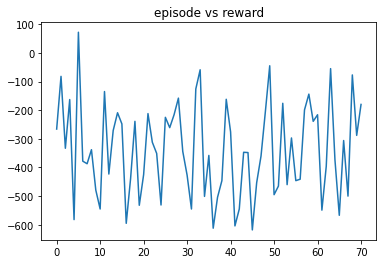

In [10]:
# episode vs reward
plt.title("episode vs reward")
plt.plot(episodes, rewards_episode)

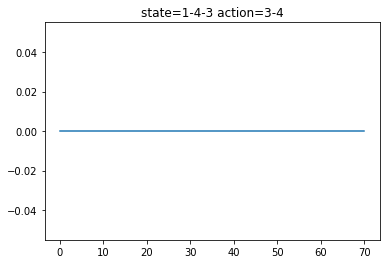

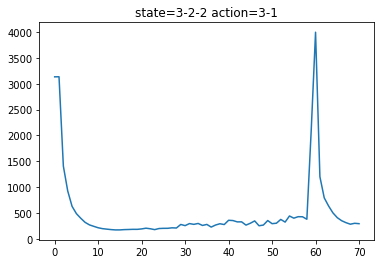

In [11]:
# state action
values = states_tracking[(1,1,3)][(0, 1)]
plt.title('state=1-4-3 action=3-4')
plt.plot(values)
plt.show()

values = states_tracking[(3,2,2)][(3,1)]
plt.title('state=3-2-2 action=3-1')
plt.plot(values)
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [12]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

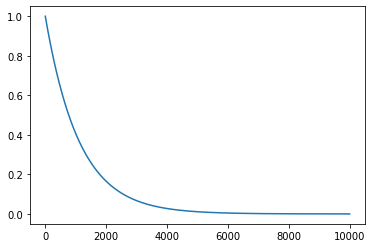

In [13]:
plt.plot(time, epsilon)
plt.show()